In [43]:
import random
import pandas as pd
import numpy as np

np.random.seed(42)

import tensorflow

tensorflow.random.set_seed(42)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, RocCurveDisplay
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from scikeras.wrappers import KerasClassifier
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from tensorflow.keras.constraints import max_norm
from warnings import filterwarnings

filterwarnings('ignore')

# Preprocessing

In [44]:
bike_df = pd.read_csv('C:/Users/adity/SeoulBikeData.csv', encoding='latin-1')

bike_df.columns = ['date', 'bike_count', 'hour', 'temperature', 'humidity', 'wind_speed', 'visibility', 'dew_point_temp', 
                   'solar_radiation', 'rainfall', 'snowfall', 'season', 'holiday', 'functioning_day']

bike_df['date'] = pd.to_datetime(bike_df['date'], format = '%d/%m/%Y')
bike_df['hour'] = bike_df['hour'].astype('category')
bike_df['season'] = bike_df['season'].astype('category')
bike_df['holiday'] = bike_df['holiday'].astype('category')
bike_df['functioning_day'] = bike_df['functioning_day'].astype('category')
bike_df['day'] = bike_df['date'].dt.day_name().astype('category')

bike_df = bike_df[bike_df['functioning_day'] == 'Yes']
bike_df = bike_df.drop(['date', 'functioning_day', 'dew_point_temp'], axis = 1)
bike_df = bike_df.reset_index(drop = True)

bike_df.head()

,bike_count,hour,temperature,humidity,wind_speed,visibility,solar_radiation,rainfall,snowfall,season,holiday,day
0,254,0,-5.2,37,2.2,2000,0.0,0.0,0.0,Winter,No Holiday,Friday
1,204,1,-5.5,38,0.8,2000,0.0,0.0,0.0,Winter,No Holiday,Friday
2,173,2,-6.0,39,1.0,2000,0.0,0.0,0.0,Winter,No Holiday,Friday
3,107,3,-6.2,40,0.9,2000,0.0,0.0,0.0,Winter,No Holiday,Friday
4,78,4,-6.0,36,2.3,2000,0.0,0.0,0.0,Winter,No Holiday,Friday


In [45]:
full_df = bike_df

full_ddf = pd.get_dummies(full_df['hour'], drop_first = True, prefix = 'hour:')
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['day'], drop_first = True, prefix = 'day:')], axis = 1)
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['season'], drop_first = True, prefix = 'season:')], axis = 1)
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['holiday'],  prefix = 'holiday:')], axis = 1)
full_ddf = full_ddf.drop('holiday:_No Holiday', axis = 1)

full_df = full_df.drop(['hour', 'day', 'season', 'holiday'], axis = 1)

y = pd.DataFrame(full_df['bike_count']).reset_index(drop = True)
c = y > np.median(y)

full_df = full_df.drop('bike_count', axis = 1)

def featureNormalize(X):
    return (X - np.mean(X, axis = 0)) / np.std(X, axis = 0, ddof = 1)

X = pd.concat([featureNormalize(full_df), full_ddf], axis = 1).reset_index(drop = True)

In [46]:
X_train = X.sample(random_state = 42, frac = 0.7).sort_index()
c_train = c[X.index.isin(X_train.index)]
X_test = X[~X.index.isin(X_train.index)]
c_test = c[~X.index.isin(X_train.index)]

# ANN Classification

## Model 1: Hyperparameters: Batch size and # of Epochs

In [47]:
def create_model1():
    model = Sequential()
    model.add(Input(shape = (40, )))
    model.add(Dense(10, activation = 'sigmoid'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])
    return model

In [48]:
nnc1_model = KerasClassifier(build_fn = create_model1, verbose = 0)

nnc1_batch_size_arr = [10, 20, 50]
nnc1_epoch_arr = [10, 50, 100]

nnc1 = GridSearchCV(estimator = nnc1_model, 
                    param_grid = {'batch_size' : nnc1_batch_size_arr, 
                                  'epochs' : nnc1_epoch_arr}, 
                    n_jobs = -1, cv = 5, return_train_score = True)

nnc1.fit(X_train.values, c_train.values.ravel())

nnc1_df = pd.DataFrame(nnc1.cv_results_)

Best Parameters: {'batch_size': 10, 'epochs': 100}
Best Cross-Validation Accuracy: 0.86


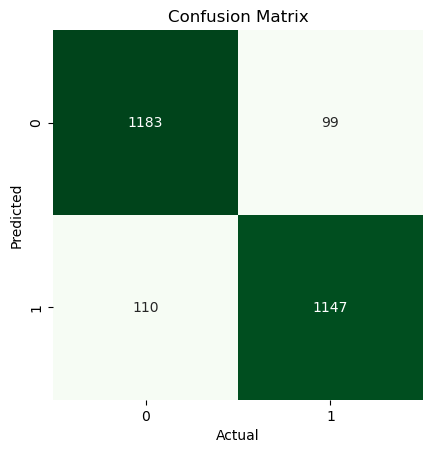

Accuracy: 0.92
Sensitivity: 0.92
Specificity: 0.91


In [50]:
print('Best Parameters: {}'.format(nnc1.best_params_))
print('Best Cross-Validation Accuracy: {:.2f}'.format(nnc1.best_score_))

pred_nnc1 = nnc1.predict(X_test)

cm_nnc1 = confusion_matrix(c_test, pred_nnc1)
tn, fp, fn, tp = cm_nnc1.ravel()

ax = sns.heatmap(cm_nnc1.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_nnc1)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

## Model 2: Activation Function of the 1st hidden layer nodes

In [51]:
def create_model2(activation = 'sigmoid'):
    model = Sequential()
    model.add(Input(shape=(40, )))
    model.add(Dense(10, activation = activation))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])
    return model

In [52]:
activation = ['linear', 'relu', 'sigmoid', 'tanh']

#nnc2_model = KerasClassifier(build_fn=create_model2, batch_size=10, epochs=100, verbose=0)

# Create a list to hold the results
results = []

# Iterate over the learning rates and momentums
for act in activation:
    #nnc2_model.set_params(activation=act)  # Set the activation for the current iteration
    nnc2_model = KerasClassifier(build_fn=create_model2, batch_size=10, epochs=100, verbose=0, activation = act)

    
    # Perform K-fold cross-validation and get train and test scores
    cv_results = cross_validate(nnc2_model, X_train.values, c_train.values.ravel(), cv=5,
                                return_train_score=True, return_estimator=True)
    
    train_scores = cv_results['train_score']
    test_scores = cv_results['test_score']
    
    # Calculate the mean of the scores
    mean_train_score = np.mean(train_scores)
    mean_test_score = np.mean(test_scores)
    
    # Append the result to the list
    results.append((act, mean_train_score, mean_test_score))

# Convert to DataFrame and Print the results
nnc2_df = pd.DataFrame(results, columns=['activation', 'mean_train_score', 'mean_test_score'])
nnc2_df

,activation,mean_train_score,mean_test_score
0,linear,0.922292,0.859103
1,relu,0.952751,0.839021
2,sigmoid,0.922461,0.860116
3,tanh,0.947351,0.847126


Best Parameters: ['sigmoid']
Best Cross-Validation Accuracy: 0.86


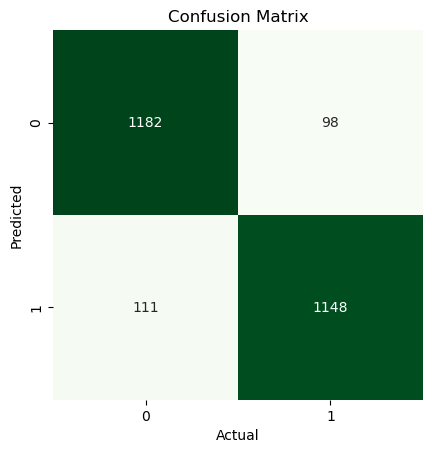

Accuracy: 0.92
Sensitivity: 0.92
Specificity: 0.91


In [53]:
# Find the maximum score value
max_score = nnc2_df['mean_test_score'].max()

# Filter the rows with the maximum score value
best_nnc2 = nnc2_df[nnc2_df['mean_test_score'] == max_score]

# Extract the 'activation' column and convert it to a numpy array
best_act = best_nnc2['activation'].values.ravel()

print('Best Parameters: {}'.format(best_act))

print('Best Cross-Validation Accuracy: {:.2f}'.format(max_score))

nnc2 = KerasClassifier(build_fn=create_model2, batch_size=10, epochs=100, verbose=0, activation = best_act[0])

nnc2.fit(X_train.values, c_train.values.ravel())

pred_nnc2 = nnc2.predict(X_test)

cm_nnc2 = confusion_matrix(c_test, pred_nnc2)
tn, fp, fn, tp = cm_nnc2.ravel()

ax = sns.heatmap(cm_nnc2.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_nnc2)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

## Model 3: Learning Rate and Momentum of the 1st hidden layer nodes

In [56]:
def create_model3(learn_rate=0.01, momentum=0.0):
    model = Sequential()
    model.add(Input(shape=(40, )))
    model.add(Dense(10, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = SGD(learning_rate=learn_rate, momentum=momentum)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [57]:
# Define the learning rates and momentums
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.5]
momentum = [0.0, 0.1, 0.2, 0.5, 0.9]

# Create a list to hold the results
results = []

# Iterate over the learning rates and momentums
for lr in learn_rate:
    for mm in momentum:
        # Create the KerasClassifier
        nnc3_model = KerasClassifier(build_fn=create_model3, batch_size=10, epochs=100, verbose=0, learn_rate=lr, momentum=mm)
        
        # Perform K-fold cross-validation and get train and test scores
        cv_results = cross_validate(nnc3_model, X_train.values, c_train.values.ravel(), cv=5,
                                    return_train_score=True, return_estimator=True)

        train_scores = cv_results['train_score']
        test_scores = cv_results['test_score']

        # Calculate the mean of the scores
        mean_train_score = np.mean(train_scores)
        mean_test_score = np.mean(test_scores)

        # Append the result to the list
        results.append((lr, mm, mean_train_score, mean_test_score))

# Convert to DataFrame and Print the results
nnc3_df = pd.DataFrame(results, columns=['learn_rate', 'momentum', 'mean_train_score', 'mean_test_score'])
nnc3_df

,learn_rate,momentum,mean_train_score,mean_test_score
0,0.001,0.0,0.833656,0.745021
1,0.001,0.1,0.843233,0.756661
2,0.001,0.2,0.844541,0.750081
3,0.001,0.5,0.873734,0.764256
4,0.001,0.9,0.922629,0.855560
5,0.010,0.0,0.922672,0.857923
6,0.010,0.1,0.922503,0.858935
7,0.010,0.2,0.923684,0.858429
8,0.010,0.5,0.928029,0.859443
9,0.010,0.9,0.962496,0.846114


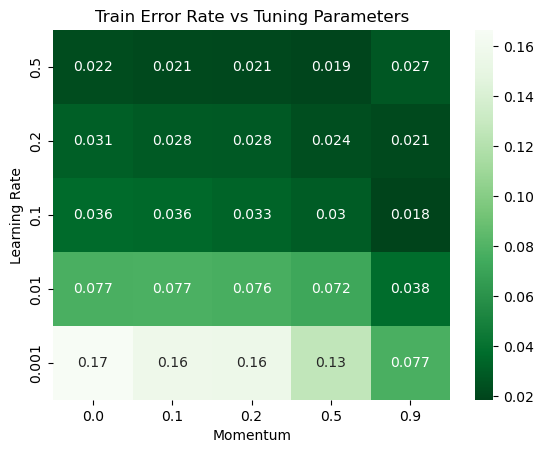

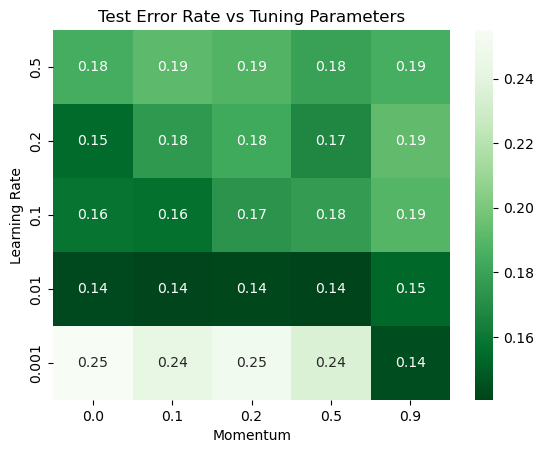

In [58]:
nnc3_train_err_mat = (1 - nnc3_df['mean_train_score']).values.reshape(len(learn_rate), len(momentum))
ax = sns.heatmap(pd.DataFrame(nnc3_train_err_mat, columns = momentum, index = learn_rate).iloc[::-1], 
                 annot = True, cmap = 'Greens_r')
ax.set(xlabel = 'Momentum', ylabel = 'Learning Rate', title = 'Train Error Rate vs Tuning Parameters')
plt.show()

nnc3_test_err_mat = (1 - nnc3_df['mean_test_score']).values.reshape(len(learn_rate), len(momentum))
ax = sns.heatmap(pd.DataFrame(nnc3_test_err_mat, columns = momentum, index = learn_rate).iloc[::-1], 
                 annot = True, cmap = 'Greens_r')
ax.set(xlabel = 'Momentum', ylabel = 'Learning Rate', title = 'Test Error Rate vs Tuning Parameters')
plt.show()

Best Parameters: {learn_rate: [0.01] , momentum: [0.5] }
Best Cross-Validation Accuracy: 0.86


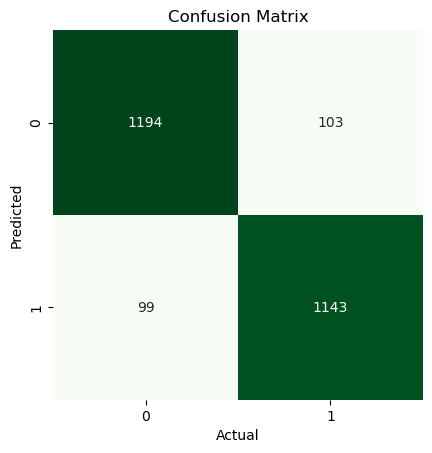

Accuracy: 0.92
Sensitivity: 0.92
Specificity: 0.92


In [60]:
# Find the maximum score value
max_score = nnc3_df['mean_test_score'].max()

# Filter the rows with the maximum score value
best_nnc3 = nnc3_df[nnc3_df['mean_test_score'] == max_score]

# Extract the 'lr' column and convert it to a numpy array
best_lr = best_nnc3['learn_rate'].values.ravel()

# Extract the 'momentum' column and convert it to a numpy array
best_mm = best_nnc3['momentum'].values.ravel()

print('Best Parameters: {learn_rate:', best_lr, ', momentum:', best_mm,'}')
print('Best Cross-Validation Accuracy: {:.2f}'.format(max_score))

nnc3 = KerasClassifier(build_fn=create_model3, batch_size=10, epochs=100, verbose=0, learn_rate=best_lr, momentum=best_mm)

nnc3.fit(X_train.values, c_train.values.ravel())

pred_nnc3 = nnc3.predict(X_test)

# Compute the confusion matrix
cm_nnc3 = confusion_matrix(c_test, pred_nnc3)
tn, fp, fn, tp = cm_nnc3.ravel()

# Plot the confusion matrix
ax = sns.heatmap(cm_nnc3.T, square=True, annot=True, fmt='d', cbar=False, cmap='Greens')
ax.set(xlabel='Actual', ylabel='Predicted', title='Confusion Matrix')
plt.show()

# Compute and print accuracy, sensitivity, and specificity
print('Accuracy: {:.2f}'.format(accuracy_score(c_test.values, pred_nnc3)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

## Model 4: Drop-out Rate and Weight Constraint of the 1st hidden layer nodes

In [61]:
def create_model4(dropout_rate=0.0, weight_constraint=0):
    model = Sequential()
    model.add(Input(shape=(40, )))
    
    if weight_constraint == 0:
        # No weight constraint
        model.add(Dense(10, activation='sigmoid'))
    else:
        # Apply max_norm constraint with the specified weight_constraint
        model.add(Dense(10, activation='sigmoid', kernel_constraint=max_norm(weight_constraint)))
    
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = SGD(learning_rate=0.01, momentum=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [62]:
wgt_constraint = [0, 1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.5, 0.9]

# Create a list to hold the results
results = []

# Iterate over the weight constraints and dropout rates
for wc in wgt_constraint:
    for dr in dropout_rate:
        # Create the KerasClassifier
        nnc4_model = KerasClassifier(build_fn=create_model4, batch_size=10, epochs=100, verbose=0,
                                     dropout_rate=dr, weight_constraint=wc)
        
        # Perform K-fold cross-validation and get train and test scores
        cv_results = cross_validate(nnc4_model, X_train.values, c_train.values.ravel(), cv=5,
                                    return_train_score=True, return_estimator=True)

        train_scores = cv_results['train_score']
        test_scores = cv_results['test_score']

        # Calculate the mean of the scores
        mean_train_score = np.mean(train_scores)
        mean_test_score = np.mean(test_scores)

        # Append the result to the list
        results.append((wc, dr, mean_train_score, mean_test_score))

# Convert to DataFrame and Print the results
nnc4_df = pd.DataFrame(results, columns=['wgt_constraint', 'dropout_rate','mean_train_score', 'mean_test_score'])
nnc4_df

,wgt_constraint,dropout_rate,mean_train_score,mean_test_score
0,0,0.0,0.928198,0.860117
1,0,0.1,0.926511,0.855056
2,0,0.2,0.923600,0.848642
3,0,0.5,0.915120,0.815227
4,0,0.9,0.852894,0.750593
5,1,0.0,0.919465,0.854040
6,1,0.1,0.908665,0.814214
7,1,0.2,0.899005,0.791092
8,1,0.5,0.863482,0.757338
9,1,0.9,0.827370,0.732192


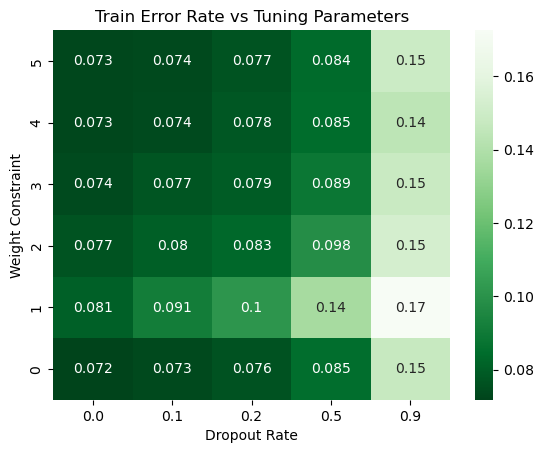

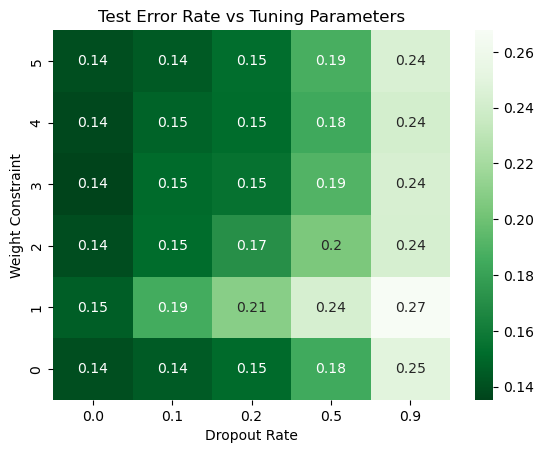

In [63]:
nnc4_train_err_mat = (1 - nnc4_df['mean_train_score']).values.reshape(len(wgt_constraint), len(dropout_rate))
ax = sns.heatmap(pd.DataFrame(nnc4_train_err_mat, columns = dropout_rate, index = wgt_constraint).iloc[::-1], 
                 annot = True, cmap = 'Greens_r')
ax.set(xlabel = 'Dropout Rate', ylabel = 'Weight Constraint', title = 'Train Error Rate vs Tuning Parameters')
plt.show()

nnc4_test_err_mat = (1 - nnc4_df['mean_test_score']).values.reshape(len(wgt_constraint), len(dropout_rate))
ax = sns.heatmap(pd.DataFrame(nnc4_test_err_mat, columns = dropout_rate, index = wgt_constraint).iloc[::-1], 
                 annot = True, cmap = 'Greens_r')
ax.set(xlabel = 'Dropout Rate', ylabel = 'Weight Constraint', title = 'Test Error Rate vs Tuning Parameters')
plt.show()

Best Parameters: {Weight Constraint: [3] , Dropout Rate [0.] }
Best Cross-Validation Accuracy: 0.86


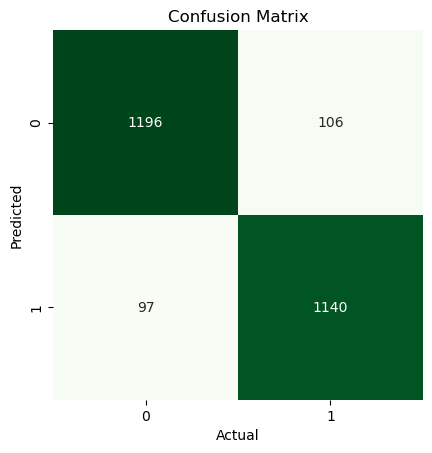

Accuracy: 0.92
Sensitivity: 0.91
Specificity: 0.92


In [65]:
# Find the maximum score value
max_score = nnc4_df['mean_test_score'].max()

# Filter the rows with the maximum score value
best_nnc4 = nnc4_df[nnc4_df['mean_test_score'] == max_score]

# Extract the 'pred' column and convert it to a numpy array
best_wc = best_nnc4['wgt_constraint'].values.ravel()
best_dr = best_nnc4['dropout_rate'].values.ravel()

print('Best Parameters: {Weight Constraint:', best_wc, ', Dropout Rate', best_dr,'}')
print('Best Cross-Validation Accuracy: {:.2f}'.format(max_score))

nnc4 = KerasClassifier(build_fn=create_model4, batch_size=10, epochs=100, verbose=0,
                                     dropout_rate=best_dr[0], weight_constraint=best_wc)

nnc4.fit(X_train.values, c_train.values.ravel())

pred_nnc4 = nnc4.predict(X_test)

cm_nnc4 = confusion_matrix(c_test, pred_nnc4)
tn, fp, fn, tp = cm_nnc4.ravel()

ax = sns.heatmap(cm_nnc4.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_nnc4)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

## Model 5: # of Neurons in the 1st hidden layer

In [66]:
def create_model5(neurons = 0):
    model = Sequential()
    model.add(Input(shape=(40, )))
    model.add(Dense(neurons, activation = 'sigmoid', kernel_constraint = max_norm(3)))
    model.add(Dropout(0.0))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = SGD(learning_rate = 0.01, momentum = 0.5)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics= ['accuracy'])
    return model

In [67]:
neurons = [1, 5, 10, 15, 20, 25, 30]

# Create a list to hold the results
results = []

# Iterate over the learning rates and momentums
for n in neurons:
    # Create the KerasClassifier
    nnc5_model = KerasClassifier(build_fn=create_model5, batch_size=10, epochs=100, verbose=0, neurons = n)
    
    # Perform K-fold cross-validation and get train and test scores
    cv_results = cross_validate(nnc5_model, X_train.values, c_train.values.ravel(), cv=5,
                                return_train_score=True, return_estimator=True)

    train_scores = cv_results['train_score']
    test_scores = cv_results['test_score']

    # Calculate the mean of the scores
    mean_train_score = np.mean(train_scores)
    mean_test_score = np.mean(test_scores)

    # Append the result to the list
    results.append((n, mean_train_score, mean_test_score))


# Convert to DataFrame and Print the results
nnc5_df = pd.DataFrame(results, columns = ['neurons', 'train_score', 'test_score'])
nnc5_df

,neurons,train_score,test_score
0,1,0.920056,0.854884
1,5,0.925034,0.861130
2,10,0.924950,0.864673
3,15,0.925962,0.864167
4,20,0.925540,0.863829
5,25,0.925456,0.863323
6,30,0.925160,0.863154


Best Parameters: {Neurons [10] }
Best Cross-Validation Accuracy: 0.86


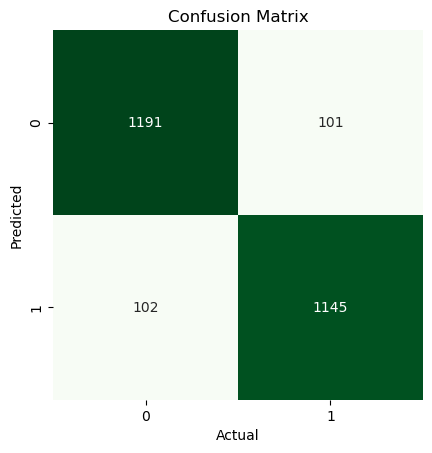

Accuracy: 0.92
Sensitivity: 0.92
Specificity: 0.92


In [68]:
# Find the maximum score value
max_score = nnc5_df['test_score'].max()

# Filter the rows with the maximum score value
best_nnc5 = nnc5_df[nnc5_df['test_score'] == max_score]

# Extract the 'pred' column and convert it to a numpy array
best_n = best_nnc5['neurons'].values.ravel()

print('Best Parameters: {Neurons', best_n, '}')
print('Best Cross-Validation Accuracy: {:.2f}'.format(max_score))

nnc5 = KerasClassifier(build_fn=create_model5, batch_size=10, epochs=100, verbose=0, neurons = best_n)

nnc5.fit(X_train.values, c_train.values.ravel())

pred_nnc5 = nnc5.predict(X_test)

cm_nnc5 = confusion_matrix(c_test, pred_nnc5)
tn, fp, fn, tp = cm_nnc5.ravel()

ax = sns.heatmap(cm_nnc5.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_nnc5)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

## Model 6: # of Neurons in the 2nd hidden layer

In [70]:
def create_model6(neurons = 0):
    model = Sequential()
    model.add(Input(shape=(40, )))
    model.add(Dense(10, activation = 'sigmoid', kernel_constraint = max_norm(3)))
    model.add(Dropout(0.0))
    model.add(Dense(neurons, activation = 'sigmoid', kernel_constraint = max_norm(3)))
    model.add(Dropout(0.0))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = SGD(learning_rate = 0.01, momentum = 0.5)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics= ['accuracy'])
    return model

In [71]:
neurons = [1, 5, 10, 15, 20, 25, 30]

# Create a list to hold the results
results = []

# Iterate over the learning rates and momentums
for n in neurons:
    # Create the KerasClassifier
    nnc6_model = KerasClassifier(build_fn=create_model6, batch_size=10, epochs=100, verbose=0, neurons = n)
    # Perform K-fold cross-validation and get train and test scores
    cv_results = cross_validate(nnc6_model, X_train.values, c_train.values.ravel(), cv=5,
                                return_train_score=True, return_estimator=True)

    train_scores = cv_results['train_score']
    test_scores = cv_results['test_score']

    # Calculate the mean of the scores
    mean_train_score = np.mean(train_scores)
    mean_test_score = np.mean(test_scores)

    # Append the result to the list
    results.append((n, mean_train_score, mean_test_score))

# Convert to DataFrame and Print the results
nnc6_df = pd.DataFrame(results, columns = ['neurons', 'train_score', 'test_score'])
nnc6_df

,neurons,train_score,test_score
0,1,0.924950,0.864335
1,5,0.932290,0.858429
2,10,0.933471,0.855562
3,15,0.932290,0.860961
4,20,0.935285,0.853706
5,25,0.935623,0.855392
6,30,0.931489,0.857924


Best Parameters: {Neurons [1] }
Best Cross-Validation Accuracy: 0.86


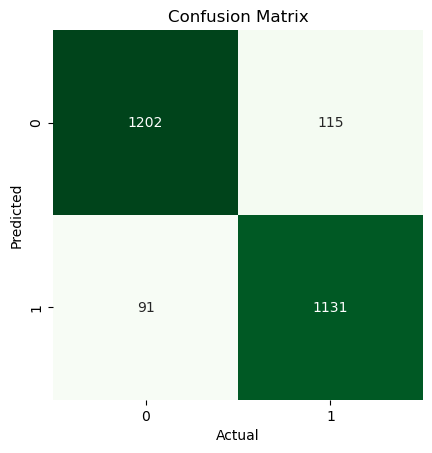

Accuracy: 0.92
Sensitivity: 0.91
Specificity: 0.93


In [72]:
# Find the maximum score value
max_score = nnc6_df['test_score'].max()

# Filter the rows with the maximum score value
best_nnc6 = nnc6_df[nnc6_df['test_score'] == max_score]

# Extract the 'pred' column and convert it to a numpy array
best_n = best_nnc6['neurons'].values.ravel()

print('Best Parameters: {Neurons', best_n, '}')
print('Best Cross-Validation Accuracy: {:.2f}'.format(max_score))

nnc6 = KerasClassifier(build_fn=create_model6, batch_size=10, epochs=100, verbose=0, neurons = best_n)

nnc6.fit(X_train.values, c_train.values.ravel())

pred_nnc6 = nnc6.predict(X_test)

cm_nnc6 = confusion_matrix(c_test, pred_nnc6)
tn, fp, fn, tp = cm_nnc6.ravel()

ax = sns.heatmap(cm_nnc6.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_nnc6)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

In [ ]:
# def final_model():
#     model = Sequential()
#     model.add(Input(shape=(40, )))
#     model.add(Dense(neurons = 10, activation = 'sigmoid', kernel_constraint = maxnorm(3)))
#     model.add(Dropout(0.0))
#     model.add(Dense(1, activation = 'sigmoid'))
#     optimizer = SGD(lr = 0.01, momentum = 0.5)
#     model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics= ['accuracy'])
#     return model
# annc_model = KerasClassifier(build_fn = final_model, batch_size = 10, epochs = 100, verbose = 0)